In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 데이터 불러오기
   - 데이터를 d라는 이름으로 불러옴
   - 초기 label이 [1,2,3,4,5] 로 구성되어 있기 때문에 학습 연산을 위해 전체적으로 1을 빼 [0,1,2,3,4] 로 만들어줌
   - 케이스를 합쳐주기 위해서 0과 1은 그대로 두고, [2,3,4] 를 하나의 label인 2로 합쳐줌

In [4]:
d = pd.read_csv('C:\\Users\\mingu\\Desktop\\data.csv')
d = d.drop('column_a',axis = 1)
d['y'] = d['y']-1
d.loc[(d['y'] != 0) & (d['y'] != 1) , 'y'] = 2
d

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x170,x171,x172,x173,x174,x175,x176,x177,x178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,2
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,0
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,2
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,2
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,15,16,12,5,-1,-18,-37,-47,-48,1
11496,-47,-11,28,77,141,211,246,240,193,136,...,-65,-33,-7,14,27,48,77,117,170,0
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,2
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,121,135,148,143,116,86,68,59,55,2


## 데이터 분포 확인
- 학습을 위해 train set과 test set으로 나눠줘야함
- label의 비율을 반영하여 나눠주기 위해서 각 label의 개수를 확인

In [5]:
print(len(d[d['y']==0]))
print(len(d[d['y']==1]))
print(len(d[d['y']==2]))

2300
2300
6900


# Train Set / Validation Set 나누기 및 정규화
- 데이터의 분포가 label 0 : 1 : 2 = 1 : 1 : 3 이었기 때문에 이를 고려하여 나눔
- 따라서 label [0,1]에 대해서는 각각 1800 : 500 으로 train set과 test set을 형성
- label [2]에 대해서는 5400 : 1500으로 train set과 test set을 형성
- train set 끼리, test set 끼리 합치고 난 후 label만을 추출해서 각 경우에 대한 label을 생성해줌

In [6]:
# 1.label이 0인 데이터들에 대한 전처리
d_0 = d[d['y']==0].copy()
d_0_train = d_0[:1800].copy()
d_0_test = d_0[1800:].copy()

# 2.label이 1인 데이터들에 대한 전처리
d_1 = d[d['y']==1].copy()
d_1_train = d_1[:1800].copy()
d_1_test = d_1[1800:].copy()

# 3.label이 2인 데이터들에 대한 전처리
d_2 = d[d['y']==2].copy()
d_2_train = d_2[:5400].copy()
d_2_test = d_2[5400:].copy()

# 1,2,3 각 경우를 합쳐 train set, validation set 형성
train = pd.concat([d_0_train, d_1_train, d_2_train])
test = pd.concat([d_0_test, d_1_test, d_2_test])

# train set을 feature와 label로 나눔
train_x = train.drop(['y'], axis = 1).copy()
train_y = train['y'].copy()

# validation set을 feature와 label로 나눔
test_x = test.drop(['y'], axis = 1).copy()
test_y = test['y'].copy()

In [7]:
# training set과 validation set의 shape 확인
print("Training shape : ", train_x.shape, train_y.shape)
print("Test shape : ",test_x.shape, test_y.shape)

Training shape :  (9000, 178) (9000,)
Test shape :  (2500, 178) (2500,)


In [8]:
# 사이킷런의 StandardScaler 라이브러리를 사용해서 특유의 노이즈가 많은 EEG신호를 정규화해줌
# 데이터의 분포가 다양하기 때문에 정규분포로 정규화 해줌
# 평균이 0, 분산이 1 인 구간으로 데이터들이 옮겨가기 때문에 원래 데이터보다 데이터의 분포를 파악하기 용이할 것이라 예상됨

from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

train_x_st = standard.fit_transform(train_x)
test_x_st = standard.fit_transform(test_x)

# Data_Iter
- 사용자의 뇌파 전극 부착 위치나 개수에 따라 신호의 개수가 달라질 수 있으므로, 임의의 L개 만큼 신호를 가져올 수 있도록 설계하였음

In [9]:
# Data_iter 함수 정의
def data_iter(batch_size, X, y, L):
    
    # 랜덤함을 부여하기 위해 X의 인덱스를 받아 shuffle
    num_examples = len(X)                     
    indices = list(range(num_examples))        
    random.shuffle(indices)                    
    
    # 학습을 위해 데이터를 batch_size 크기로 나눠서 받음
    # 전체 데이터를 한바퀴 순회함 : 1 epoch
    # 각 feature에서 임의의 L개만큼 가져오기 위해서 randint를 통해 랜덤하게 L개를 가져올수 있도록 함
    # feature tensor와 label tensor를 zero tensor로 초기화하고, L개만큼 그리고 해당하는 label을 받아올 수 있도록 함
    # batch_indices에 랜덤하게 섞은 indices를 슬라이싱해서 인덱스를 받아줌
    # 민약 i + batch_size가 총 데이터의 길이보다 길어지면 마지막 데이터까지만 받아옴
    # ex) i = 310, batch_size = 10이면 마지막에는 인덱스 310:314 까지만 슬라이싱해서 받음
    # yield 로 batch_size만큼의 X와 y를 반환해줌 - generator 형식
    
    for i in range(0, num_examples, batch_size): 
        r1 = random.randint(0,40)
        features = torch.zeros(batch_size,L)
        labels = torch.zeros(batch_size,)
        
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        features = torch.tensor(np.array(train_x_st[batch_indices,r1:r1+L]))
        labels = torch.tensor(np.array(train_y.iloc[batch_indices])).to(torch.float32)
        yield features, labels

torch.Size([10, 100])
torch.Size([10])


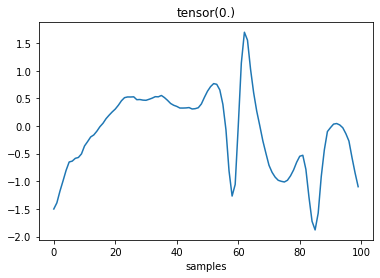

In [10]:
# data_iter 함수가 제대로 작동하는지 확인하기 위해 EEG 신호의 파형 출력
# 제대로 작동 시 L sample만큼의 파형을 출력해줌
L = 100
for X_tr, y_tr in data_iter(10,train_x_st,train_y,L):
    print(X_tr.shape)
    print(y_tr.shape)
    for n in range(1):
        plt.plot(X_tr[n])
        plt.title(y_tr[n])
        plt.xlabel('samples')
        plt.show()
    break

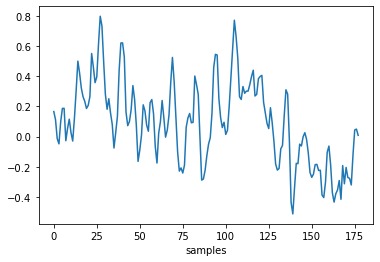

In [11]:
# test set의 파형을 plot 
# label마다 어떤 형태의 파형을 가지고 있는지 대략적인 유추가 가능함
plt.plot(test_x_st[2497])
plt.xlabel('samples')
plt.show()

# 모델 정의
- myRNN 이라는 이름을 가진 클래스 정의
- 기본적으로 LSTM의 학습 방법을 가지며, 배치사이즈를 첫번째 인수로 받아오고 bidirectinal은 False로 설정함
- LSTM의 dropout은 0.3으로 설정하여 40개의 hidden layer에 대해서 적절한 dropout을 하도록 하였음
- LSTM 과정을 거치면 forward 함수에서 정의한 순서에 따라 classifier, output연산이 순서대로 진행됨
- 몇번의 Linear 연산을 거친 후에 ReLU를 통해서 nonlinear 함 역시 파악할 수 있도록 설계하였음
- 이 classifier 역시 dropout = 0.3으로 정의
- 마지막으로 Linear 모델을 거쳐 output이 출력되도록 함 

In [31]:
class myRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        
        super().__init__()

        self.features = torch.nn.Sequential(    
            
            torch.nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=False,
                          dropout=0.3)
    )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 20),
            torch.nn.Linear(20,40),
            torch.nn.Linear(40,20),
            torch.nn.Linear(20, hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.3),
        )
        
        self.output = torch.nn.Linear(hidden_size, out_size)

    def forward(self, x):
        features, _ = self.features(x)
        output = self.classifier(features)
        output = self.output(output)
        return output

In [32]:
# myRNN의 이름을 net으로 지정해줌
# input_size = 15, hidden_size = 40, num_layer = 2, output_layer = 3으로 지정함
# label의 경우가 3개이기 때문에 output을 3으로 지정
net = myRNN(15,40,2,3)
net.to(device)

myRNN(
  (features): Sequential(
    (0): LSTM(15, 40, num_layers=2, batch_first=True, dropout=0.3)
  )
  (classifier): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=40, out_features=40, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=40, out_features=3, bias=True)
)

# Loss Function / Optimizer 정의
- learning_rate = 0.001 로 설정하였음
- loss function으로는 CrossEntropyLoss를 사용하였으며, weight initialization을 위해 torch.nn.init.uniform_을 사용해서 모든 값이 균일한 분포를 따르도록 초기화
- Optimization algorithm으로는 Adam을 사용하여 sgd와 momentum을 모두 고려할 수 있도록 생성함
- 이때 그래디언트와 그 제곱의 실행 평균을 계산하는 데 사용되는 계수인 betas는 default 값인 (0.9, 0.999)로 설정함
- accuracy 시각화를 위해 epoch 마다의 accuracy를 저장할 리스트 epoch_tr_accuracy, epoch_vd_accuracy 생성

In [33]:
learning_rate = 0.001

tensor = torch.empty(3)
loss = nn.CrossEntropyLoss(weight=torch.nn.init.uniform_(tensor),reduction='mean')
alg = torch.optim.Adam(net.parameters(), lr = learning_rate, betas=(0.9, 0.999))

epoch_tr_accuracy = []
epoch_vd_accuracy = []

# 모델 학습하기
- 정의한 hyperparameter를 가지고 학습 진행

In [34]:
learning_rate = 0.001
eval_interval = 1
num_epochs = 3000
batch_size = 400
L = 120

for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    net.train()
    
    # data_iter함수를 호출하여 train feature와 train label을 가져옴
    # 정의해준 L이 120이기 때문에 .view 함수를 통해 15개씩 8 묶음으로 묶어서 학습을 진행함
    # myRNN에 feature를 넣어줌으로써 학습 진행 - 예측값 y_tr_pred 생성
    # y_tr_pred와 실제 label 값을 비교하여 loss 계산
    # 이후 backpropagation과 gradient 초기화를 계속 하며 모델의 학습을 진행함
    # argmax 함수를 통해 모델의 출력 output 3개 중에서 가장 큰 값의 인덱스를 받아서 softmax연산을 진행
    for X_tr, y_tr in data_iter(batch_size, train_x_st, train_y,L):
        X = X_tr.view(len(X_tr),8,15).to(torch.float32)
        y_tr_pred = net(X.to(device))
        y_tr_pred = y_tr_pred[:,-1,:]
        l=loss(y_tr_pred.cpu(),y_tr.type(torch.LongTensor))
        l.backward()    
        alg.step()
        alg.zero_grad()
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.cpu().softmax(1),dim=1)).numpy()
        N += len(X_tr)
        i=i+1

    # data_iter함수를 호출하여 validation feature와 validation label을 가져옴    
    # 학습과정에서 얻은 예측이 맞은 개수 Ncorrect를 전체 개수 N으로 나눠 training accuracy를 얻음
    # net.eval() 함수를 호출하여 평가 단계에서 코드를 진행함
    # 위의 학습과정과 동일하게 진행되며, validation set에 대한 accuracy를 얻음
    if epoch%eval_interval==0:
        tr_accuracy = 100*Ncorrect/(N)
        net.eval()
        for X_vd, y_vd in data_iter(len(test_x_st), test_x_st, test_y,L):
            X = X_vd.view(len(test_x_st),8,15).to(torch.float32)
            with torch.no_grad():
                y_vd_pred = net(X.to(device))
            y_vd_pred = y_vd_pred[:,-1,:]            
            vd_accuracy = 100*torch.sum(y_vd==torch.argmax(y_vd_pred.cpu().softmax(1),dim=1))/(len(test_x_st)) 
        
        if epoch%5==0:
            print(f'epoch #{epoch}')
            print(f'accuracy of train set: {tr_accuracy} %')
            print(f'accuracy of valid set: {vd_accuracy} %')
        epoch_tr_accuracy.append(tr_accuracy)
        epoch_vd_accuracy.append(vd_accuracy)

epoch #0
accuracy of train set: 40.611111111111114 %
accuracy of valid set: 0.0 %
epoch #5
accuracy of train set: 78.24444444444444 %
accuracy of valid set: 69.08000183105469 %
epoch #10
accuracy of train set: 78.4 %
accuracy of valid set: 70.0 %
epoch #15
accuracy of train set: 78.77777777777777 %
accuracy of valid set: 70.5199966430664 %
epoch #20
accuracy of train set: 78.87777777777778 %
accuracy of valid set: 73.19999694824219 %
epoch #25
accuracy of train set: 78.91111111111111 %
accuracy of valid set: 72.36000061035156 %
epoch #30
accuracy of train set: 79.5 %
accuracy of valid set: 76.23999786376953 %
epoch #35
accuracy of train set: 80.05555555555556 %
accuracy of valid set: 73.19999694824219 %
epoch #40
accuracy of train set: 80.21111111111111 %
accuracy of valid set: 74.4000015258789 %
epoch #45
accuracy of train set: 79.64444444444445 %
accuracy of valid set: 76.27999877929688 %
epoch #50
accuracy of train set: 79.93333333333334 %
accuracy of valid set: 77.0 %
epoch #55
acc

epoch #435
accuracy of train set: 86.4888888888889 %
accuracy of valid set: 90.23999786376953 %
epoch #440
accuracy of train set: 86.94444444444444 %
accuracy of valid set: 86.12000274658203 %
epoch #445
accuracy of train set: 86.08888888888889 %
accuracy of valid set: 91.72000122070312 %
epoch #450
accuracy of train set: 85.87777777777778 %
accuracy of valid set: 88.83999633789062 %
epoch #455
accuracy of train set: 86.47777777777777 %
accuracy of valid set: 87.55999755859375 %
epoch #460
accuracy of train set: 86.22222222222223 %
accuracy of valid set: 90.19999694824219 %
epoch #465
accuracy of train set: 86.08888888888889 %
accuracy of valid set: 85.16000366210938 %
epoch #470
accuracy of train set: 85.96666666666667 %
accuracy of valid set: 90.04000091552734 %
epoch #475
accuracy of train set: 86.3 %
accuracy of valid set: 88.91999816894531 %
epoch #480
accuracy of train set: 85.96666666666667 %
accuracy of valid set: 88.5199966430664 %
epoch #485
accuracy of train set: 86.52222222

epoch #870
accuracy of train set: 89.27777777777777 %
accuracy of valid set: 92.16000366210938 %
epoch #875
accuracy of train set: 88.57777777777778 %
accuracy of valid set: 91.63999938964844 %
epoch #880
accuracy of train set: 89.08888888888889 %
accuracy of valid set: 89.55999755859375 %
epoch #885
accuracy of train set: 88.95555555555555 %
accuracy of valid set: 91.83999633789062 %
epoch #890
accuracy of train set: 88.42222222222222 %
accuracy of valid set: 87.44000244140625 %
epoch #895
accuracy of train set: 89.16666666666667 %
accuracy of valid set: 91.5999984741211 %
epoch #900
accuracy of train set: 89.36666666666666 %
accuracy of valid set: 91.91999816894531 %
epoch #905
accuracy of train set: 89.32222222222222 %
accuracy of valid set: 89.95999908447266 %
epoch #910
accuracy of train set: 88.92222222222222 %
accuracy of valid set: 93.4000015258789 %
epoch #915
accuracy of train set: 89.23333333333333 %
accuracy of valid set: 92.23999786376953 %
epoch #920
accuracy of train set

epoch #1300
accuracy of train set: 90.62222222222222 %
accuracy of valid set: 94.63999938964844 %
epoch #1305
accuracy of train set: 90.43333333333334 %
accuracy of valid set: 93.5199966430664 %
epoch #1310
accuracy of train set: 90.58888888888889 %
accuracy of valid set: 94.5999984741211 %
epoch #1315
accuracy of train set: 90.5 %
accuracy of valid set: 94.68000030517578 %
epoch #1320
accuracy of train set: 90.0111111111111 %
accuracy of valid set: 94.12000274658203 %
epoch #1325
accuracy of train set: 90.83333333333333 %
accuracy of valid set: 94.31999969482422 %
epoch #1330
accuracy of train set: 90.62222222222222 %
accuracy of valid set: 93.08000183105469 %
epoch #1335
accuracy of train set: 90.42222222222222 %
accuracy of valid set: 93.4800033569336 %
epoch #1340
accuracy of train set: 90.38888888888889 %
accuracy of valid set: 94.44000244140625 %
epoch #1345
accuracy of train set: 90.92222222222222 %
accuracy of valid set: 92.5199966430664 %
epoch #1350
accuracy of train set: 90.

epoch #1730
accuracy of train set: 91.63333333333334 %
accuracy of valid set: 94.72000122070312 %
epoch #1735
accuracy of train set: 92.13333333333334 %
accuracy of valid set: 96.5999984741211 %
epoch #1740
accuracy of train set: 92.28888888888889 %
accuracy of valid set: 94.76000213623047 %
epoch #1745
accuracy of train set: 92.24444444444444 %
accuracy of valid set: 95.16000366210938 %
epoch #1750
accuracy of train set: 91.4888888888889 %
accuracy of valid set: 94.91999816894531 %
epoch #1755
accuracy of train set: 92.0 %
accuracy of valid set: 97.23999786376953 %
epoch #1760
accuracy of train set: 91.64444444444445 %
accuracy of valid set: 95.55999755859375 %
epoch #1765
accuracy of train set: 91.84444444444445 %
accuracy of valid set: 97.36000061035156 %
epoch #1770
accuracy of train set: 91.94444444444444 %
accuracy of valid set: 96.27999877929688 %
epoch #1775
accuracy of train set: 91.71111111111111 %
accuracy of valid set: 96.16000366210938 %
epoch #1780
accuracy of train set: 

epoch #2160
accuracy of train set: 92.53333333333333 %
accuracy of valid set: 95.87999725341797 %
epoch #2165
accuracy of train set: 93.07777777777778 %
accuracy of valid set: 95.95999908447266 %
epoch #2170
accuracy of train set: 92.47777777777777 %
accuracy of valid set: 95.5199966430664 %
epoch #2175
accuracy of train set: 92.5111111111111 %
accuracy of valid set: 97.19999694824219 %
epoch #2180
accuracy of train set: 92.88888888888889 %
accuracy of valid set: 97.04000091552734 %
epoch #2185
accuracy of train set: 92.86666666666666 %
accuracy of valid set: 96.76000213623047 %
epoch #2190
accuracy of train set: 92.72222222222223 %
accuracy of valid set: 96.31999969482422 %
epoch #2195
accuracy of train set: 92.28888888888889 %
accuracy of valid set: 97.36000061035156 %
epoch #2200
accuracy of train set: 92.9 %
accuracy of valid set: 97.5199966430664 %
epoch #2205
accuracy of train set: 92.2 %
accuracy of valid set: 97.55999755859375 %
epoch #2210
accuracy of train set: 92.23333333333

epoch #2590
accuracy of train set: 92.84444444444445 %
accuracy of valid set: 97.5199966430664 %
epoch #2595
accuracy of train set: 93.45555555555555 %
accuracy of valid set: 96.80000305175781 %
epoch #2600
accuracy of train set: 93.4 %
accuracy of valid set: 95.76000213623047 %
epoch #2605
accuracy of train set: 93.58888888888889 %
accuracy of valid set: 96.87999725341797 %
epoch #2610
accuracy of train set: 93.78888888888889 %
accuracy of valid set: 96.4000015258789 %
epoch #2615
accuracy of train set: 93.35555555555555 %
accuracy of valid set: 97.19999694824219 %
epoch #2620
accuracy of train set: 93.0111111111111 %
accuracy of valid set: 98.08000183105469 %
epoch #2625
accuracy of train set: 93.57777777777778 %
accuracy of valid set: 96.04000091552734 %
epoch #2630
accuracy of train set: 93.5 %
accuracy of valid set: 97.04000091552734 %
epoch #2635
accuracy of train set: 93.31111111111112 %
accuracy of valid set: 97.31999969482422 %
epoch #2640
accuracy of train set: 92.97777777777

# Accuracy Curve

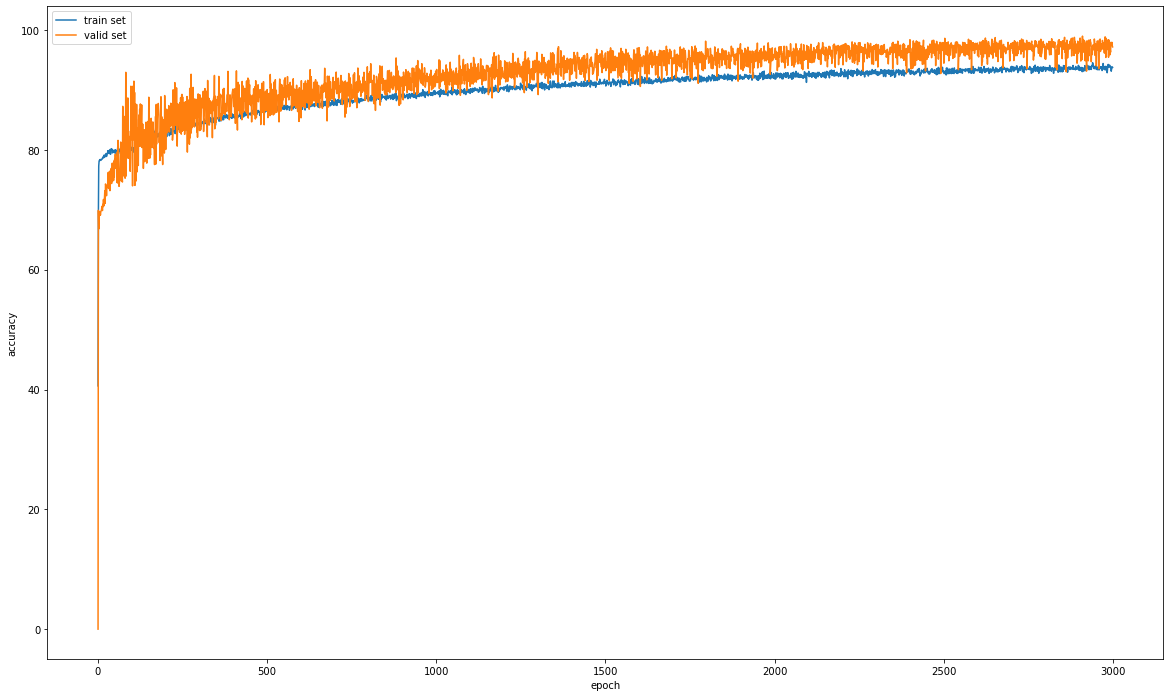

In [35]:
# train accuracy와 validation accuracy 시각화
plt.figure(figsize = (20,12))
plt.plot(epoch_tr_accuracy)
plt.plot(epoch_vd_accuracy)
plt.legend(['train set','valid set'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Confusion Matrix

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from enum import Enum

In [42]:
input_size = 15
y_hat_vd = np.array([])

# test set의 feature만 정규화. np.array 형태.
dlist = test_x_st
y_vd = np.concatenate((np.zeros(len(test[test['y']==0])),np.ones(len(test[test['y']==1])),
                       np.zeros(len(test[test['y']==2]))+2),axis=0).astype('int64')

# 정의한 net이 15개의 입력을 받기 때문에 input_size는 15로 설정.
# argmax를 통해 가장 확률이 높은 인덱스를 받아 예측 결과를 생성.
for n in range(len(dlist)):
    a = dlist
    a = a[n]
    N = int(np.ceil(len(a)/input_size))
    a = np.pad(a,[0 ,N*input_size-len(a)])
    X = torch.Tensor(a).view(1,N,input_size)
    y_hat = net(X.to(device))
    y_hat = y_hat[:,-1,:]   
    y_hat_vd = np.append(y_hat_vd,torch.argmax(y_hat.cpu().softmax(1),dim=1))

                    precision    recall  f1-score   support

Epileptic_Seizures       0.97      0.97      0.97       500
             Tumor       0.63      0.65      0.64       500
            Normal       0.88      0.87      0.88      1500

          accuracy                           0.85      2500
         macro avg       0.83      0.83      0.83      2500
      weighted avg       0.85      0.85      0.85      2500



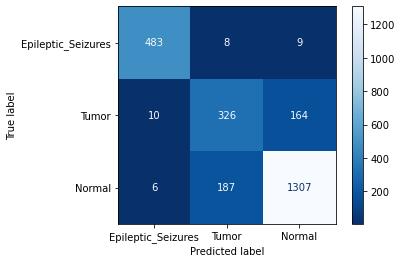

In [67]:
# classification report, confusion matrix 생성
class Diagnosis(Enum):
    Epileptic_Seizures = 0
    Tumor = 1    
    Normal = 2

print(classification_report(
    y_vd,
    y_hat_vd,
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y_vd,
    y_hat_vd,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1], cmap = 'Blues_r')

# Inference를 위한 파라미터 파일 생성
- 파이토치 튜토리얼 참고
- https://tutorials.pytorch.kr/recipes/recipes/saving_and_loading_models_for_inference.html

In [68]:
# 파라미터 저장 경로 설정
PATH_param = "C:\\Users\\mingu\\Desktop\\state_dict_model.pt"

# 파라미터 저장
torch.save(net.state_dict(), PATH_param)

# 파라미터 로드
net.load_state_dict(torch.load(PATH_param))
net.eval()

myRNN(
  (features): Sequential(
    (0): LSTM(15, 40, num_layers=2, batch_first=True, dropout=0.3)
  )
  (classifier): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=40, out_features=40, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=40, out_features=3, bias=True)
)

In [70]:
# 업데이트된 파라미터 확인
net.state_dict()

OrderedDict([('features.0.weight_ih_l0',
              tensor([[ 0.3825,  0.1696,  0.3888,  ..., -0.0149, -0.2796, -1.0081],
                      [ 1.0355,  0.5075,  0.2560,  ...,  0.2613,  0.3488, -0.2009],
                      [-0.4147, -0.5194, -0.4410,  ..., -0.0834,  0.1688,  0.4171],
                      ...,
                      [-0.6725, -0.4227, -0.0128,  ..., -0.2711, -0.3587, -0.4195],
                      [-0.1928, -0.1214,  0.5168,  ...,  0.1447, -0.2058, -0.0991],
                      [ 0.2795,  0.3319,  0.5523,  ...,  0.0381,  0.1327,  0.0728]])),
             ('features.0.weight_hh_l0',
              tensor([[ 0.5270, -0.2079, -0.4816,  ..., -0.3560,  0.3740,  0.4470],
                      [-0.0881, -0.4017,  0.0637,  ..., -1.4737, -1.3834,  1.5079],
                      [-0.3759, -0.4179, -0.2526,  ..., -0.3713,  0.2377, -1.0464],
                      ...,
                      [-0.5668, -0.5449, -0.3781,  ..., -0.5061,  0.1073, -0.1213],
                     